# G-Code and STL visualization

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
from mpl_toolkits import mplot3d

import meshcut
from stl import mesh
import numpy.linalg as la

#--- for gcode parser
from pygcode import *
from pygcode import Line
from pygcode import Machine, GCodeRapidMove

%matplotlib inline

In [2]:
# Load and process STL file (https://github.com/julienr/meshcut/blob/master/examples/utils.py)

def points3d(verts, point_size=3, **kwargs):
    if 'mode' not in kwargs:
        kwargs['mode'] = 'point'
    p = mlab.points3d(verts[:, 0], verts[:, 1], verts[:, 2], **kwargs)
    p.actor.property.point_size = point_size


def trimesh3d(verts, faces, **kwargs):
    mlab.triangular_mesh(verts[:, 0], verts[:, 1], verts[:, 2], faces,
                         **kwargs)


def orthogonal_vector(v):
    """Return an arbitrary vector that is orthogonal to v"""
    if v[1] != 0 or v[2] != 0:
        c = (1, 0, 0)
    else:
        c = (0, 1, 0)
    return np.cross(v, c)


def show_plane(orig, n, scale=1.0, **kwargs):
    """
    Show the plane with the given origin and normal. scale give its size
    """
    b1 = orthogonal_vector(n)
    b1 /= la.norm(b1)
    b2 = np.cross(b1, n)
    b2 /= la.norm(b2)
    verts = [orig + scale*(-b1 - b2),
             orig + scale*(b1 - b2),
             orig + scale*(b1 + b2),
             orig + scale*(-b1 + b2)]
    faces = [(0, 1, 2), (0, 2, 3)]
    trimesh3d(np.array(verts), faces, **kwargs)
    
def load_stl(stl_fname):
    import stl
    m = stl.mesh.Mesh.from_file(stl_fname)

    # Flatten our vert array to Nx3 and generate corresponding faces array
    verts = m.vectors.reshape(-1, 3)
    faces = np.arange(len(verts)).reshape(-1, 3)

    verts, faces = meshcut.merge_close_vertices(verts, faces)
    return verts, faces

def show(plane):
    P = meshcut.cross_section_mesh(mesh, plane)
    colors = [
        (0, 1, 1),
        (1, 0, 1),
        (0, 0, 1)
    ]
    print("num contours : ", len(P))

    if True:
        utils.trimesh3d(mesh.verts, mesh.tris, color=(1, 1, 1),
                            opacity=0.5, representation='wireframe')
        utils.show_plane(plane.orig, plane.n, scale=1, color=(1, 0, 0),
                             opacity=0.5)

        for p, color in zip(P, itertools.cycle(colors)):
            p = np.array(p)
            mlab.plot3d(p[:, 0], p[:, 1], p[:, 2], tube_radius=None,
                            line_width=3.0, color=color)
    return P

In [3]:
layer_height = 0.4
layer_number = 33-2
z_height = layer_height*layer_number
print("z-height = {} mm".format(z_height))

z-height = 12.4 mm


In [4]:
verts1, faces1 = load_stl('misc_data/70mm_low_poly_fox_MatterControl.stl')
mesh1 = mesh.Mesh.from_file('misc_data/70mm_low_poly_fox_MatterControl.stl')

volume1, cog1, inertia1 = mesh1.get_mass_properties()
print("Volume                                  = {0}".format(volume1))
print("Position of the center of gravity (COG) = {0}".format(cog1))
print("Inertia matrix at expressed at the COG  = {0}".format(inertia1[0,:]))
print("                                          {0}".format(inertia1[1,:]))
print("                                          {0}".format(inertia1[2,:]))

mesh_plane = meshcut.TriangleMesh(verts1, faces1)

def show(mesh,plane):
    P = meshcut.cross_section_mesh(mesh, plane)
    print("num contours : ", len(P))
    if True:
        utils.trimesh3d(mesh.verts, mesh.tris, color=(1, 1, 1),
                            opacity=0.5, representation='wireframe')
        utils.show_plane(plane.orig, plane.n, scale=1, color=(1, 0, 0),
                             opacity=0.5)
        for p, color in zip(P, itertools.cycle(colors)):
            p = np.array(p)
            mlab.plot3d(p[:, 0], p[:, 1], p[:, 2], tube_radius=None,
                            line_width=3.0, color=color)
    return P

plane_orig_1 = (0, 0, z_height)
plane_norm_1 = (0, 0, 1)
plane_norm_1 /= la.norm(plane_norm_1)

stl_plane_1 = meshcut.Plane(plane_orig_1, plane_norm_1)

P0 = meshcut.cross_section_mesh(mesh_plane,meshcut.Plane((0, 0, 0), (0, 0, 1)))
P1 = meshcut.cross_section_mesh(mesh_plane,stl_plane_1)

Your mesh is not closed, the mass methods will not function
            correctly on this mesh.  For more info:
            https://github.com/WoLpH/numpy-stl/issues/69


Volume                                  = 37809.573435098086
Position of the center of gravity (COG) = [ 2.36582563 -1.56621073 24.38806079]
Inertia matrix at expressed at the COG  = [16055170.96416719  -729930.11880064  1027982.23488023]
                                          [ -729930.11880064 13667449.51363609  4373735.79149251]
                                          [1027982.23488023 4373735.79149251 6557198.77419367]


In [5]:
part_height = np.max(mesh1.vectors[:,:,2])-np.min(mesh1.vectors[:,:,2])
print('Total height of the part = {} mm'.format(part_height))

Total height of the part = 70.0 mm


In [6]:
# Printing Bed Definition

x_max_bed = 90 # mm
y_max_bed = 90 # mm
z_max_bed = 50 # mm
img_size  = 500 # 500x500 pixels

visual_markers = np.array([[-75,-75,0],[75,-75,0],[75,75,0],[-75,75,0]])

h_plane_1 = np.array([[-45,-45,z_height],[45,-45,z_height],[45,45,z_height],[-45,45,z_height]])

workspace_definition = [(-45,-45,0), (-45,y_max_bed/2,0), (x_max_bed/2,-45,0), (-45,-45,z_max_bed)]
workspace_definition_array = [np.array(list(item)) for item in workspace_definition]

# Origin
x = 0
y = 0
z = 0

xx_base, yy_base = np.meshgrid(range(-100,100), range(-100,100))
zz_base = np.zeros((200,200), dtype=int)

# Camera location
cam_pos = np.array([0,-260,100]) # Main Camera Location
side_pos = np.array([180,0,8]) # Side Camera Location

In [7]:
# Object Transformation H

otheta_x = 0.0 # degrees
otheta_y = 0.0 # degrees
otheta_z = 0.0 # degrees

ot_x = 0.0
ot_y = 0.0
ot_z = 0.0

oRx = np.array([[1,0,0],[0,np.cos(otheta_x*np.pi/180),-np.sin(otheta_x*np.pi/180)],\
               [0,np.sin(otheta_x*np.pi/180),np.cos(otheta_x*np.pi/180)]]) # rotation around x
oRy = np.array([[np.cos(otheta_y*np.pi/180),0,np.sin(otheta_y*np.pi/180)],[0,1,0],\
               [-np.sin(otheta_y*np.pi/180),0,np.cos(otheta_y*np.pi/180)]]) # rotation around x
oRz = np.array([[np.cos(otheta_z*np.pi/180),-np.sin(otheta_z*np.pi/180),0],\
               [np.sin(otheta_z*np.pi/180),np.cos(otheta_z*np.pi/180),0],[0,0,1]]) # rotation around x

oR = np.dot(np.dot(oRx,oRy),oRz)
ot = np.array([ot_x,ot_y,ot_z])

#print('oRx = \n{}\n'.format(oRx))
#print('oRy = \n{}\n'.format(oRy))
#print('oRz = \n{}\n'.format(oRz))
#print('\noR = \n{}\n'.format(oR))
#print('\not = \n{}\n'.format(ot.T))

H = np.zeros((4,4), dtype=float)
H[0:3,0:3] = oR
H[0:3,3] = ot.T
H[3,3] = 1

print('\nH = \n{}\n'.format(H))


H = 
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]



In [8]:
# Intrinsic Camera Parameters

fx = 1000.0
fy = 1000.0
cx = 0
cy = 0

cam_mtx = np.array([[fx,        0,     cx],
                    [0,         fy,    cy],
                    [0,         0,     1]])

print('Camera Intrinsic Parameters = \n\n{}'.format(cam_mtx))

Camera Intrinsic Parameters = 

[[1000.    0.    0.]
 [   0. 1000.    0.]
 [   0.    0.    1.]]


In [9]:
# Intrinsic camera parameters (obtained on the calibration stage)
# Source images have already been undistorted

camera_intrinsic_K = np.array(
                         [[1552.3, 0,      650.1],
                         [0,       1564.8, 486.2],
                         [0,       0,      1]], dtype = "float")
print("Camera Intrinsic Parameters :\n {}".format(camera_intrinsic_K))

Camera Intrinsic Parameters :
 [[1.5523e+03 0.0000e+00 6.5010e+02]
 [0.0000e+00 1.5648e+03 4.8620e+02]
 [0.0000e+00 0.0000e+00 1.0000e+00]]


In [10]:
# Camera Transformation C

theta_x = -120.0 # degrees
theta_y = 0.0 # degrees
theta_z = 0.0 # degrees

t_x = -50.0
t_y = -30.0
t_z = 120.0

Rx = np.array([[1,0,0],[0,np.cos(theta_x*np.pi/180),-np.sin(theta_x*np.pi/180)],\
               [0,np.sin(theta_x*np.pi/180),np.cos(theta_x*np.pi/180)]]) # rotation around x
Ry = np.array([[np.cos(theta_y*np.pi/180),0,np.sin(theta_y*np.pi/180)],[0,1,0],\
               [-np.sin(theta_y*np.pi/180),0,np.cos(theta_y*np.pi/180)]]) # rotation around x
Rz = np.array([[np.cos(theta_z*np.pi/180),-np.sin(theta_z*np.pi/180),0],\
               [np.sin(theta_z*np.pi/180),np.cos(theta_z*np.pi/180),0],[0,0,1]]) # rotation around x

R = np.dot(np.dot(Rx,Ry),Rz)
t = np.array([t_x,t_y,t_z])

#print('Rx = \n{}\n'.format(Rx))
#print('Ry = \n{}\n'.format(Ry))
#print('Rz = \n{}\n'.format(Rz))
#print('\nR = \n{}\n'.format(R))
#print('\nt = \n{}\n'.format(t.T))

C = np.zeros((4,4), dtype=float)
C[0:3,0:3] = R
C[0:3,3] = t.T
C[3,3] = 1

print('\nC = \n{}\n'.format(C))


C = 
[[  1.          0.          0.        -50.       ]
 [  0.         -0.5         0.8660254 -30.       ]
 [  0.         -0.8660254  -0.5       120.       ]
 [  0.          0.          0.          1.       ]]



In [11]:
# Viewing Frustum V

aspect=1.0
alpha=2.0
far = 80.0
near=8.0

q = 1/np.tan(alpha/2)
a=q/aspect
b=(far+near)/(near-far)
c=(2*far*near)/(near-far)

V = np.array([[a,0,0,0],[0,q,0,0],[0,0,b,c],[0,0,-1,0]])
V

array([[  0.64209262,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.64209262,   0.        ,   0.        ],
       [  0.        ,   0.        ,  -1.22222222, -17.77777778],
       [  0.        ,   0.        ,  -1.        ,   0.        ]])

In [12]:
# Sensor Parameters (https://dashcamtalk.com/cams/lk-7950-wd/Sony_IMX322.pdf)

sensor_width  = 2000*2.8e-6*1000
sensor_height = 1121*2.8e-6*1000

print('Sensor Size = {}x{} mm'.format(sensor_width,sensor_height))

print('\n\nSensor Ratio = {}'.format((sensor_width)/(sensor_height)))
print('16/9 Ratio = {}'.format(16/9))
print('1920/1080 Ratio = {}'.format(1920/1080))

Sensor Size = 5.6x3.1388 mm


Sensor Ratio = 1.784121320249777
16/9 Ratio = 1.7777777777777777
1920/1080 Ratio = 1.7777777777777777


In [13]:
# Camera Location

cam_main = np.array([0,0,0,1]) # Main Camera Location
cam_main_x = np.array([cam_main[0]+25,cam_main[1],cam_main[2],1])
cam_main_y = np.array([cam_main[0],cam_main[1]+25,cam_main[2],1])
cam_main_z = np.array([cam_main[0],cam_main[1],cam_main[2]+25,1])

cam_main = np.array([cam_main,cam_main_x,cam_main_y,cam_main_z])

print('Main Camera Matrix = \n\n{}\n'.format(cam_main))
print('Main Camera Matrix Shape = {}'.format(np.shape(cam_main)))

print('\n\nInitial camera origin = cam_main[0] = {}'.format(cam_main[0]))
print('Camera x-axis = cam_main[1] = {}'.format(cam_main[1]))
print('Camera y-axis = cam_main[2] = {}'.format(cam_main[2]))
print('Camera z-axis = cam_main[3] = {}'.format(cam_main[3]))

Main Camera Matrix = 

[[ 0  0  0  1]
 [25  0  0  1]
 [ 0 25  0  1]
 [ 0  0 25  1]]

Main Camera Matrix Shape = (4, 4)


Initial camera origin = cam_main[0] = [0 0 0 1]
Camera x-axis = cam_main[1] = [25  0  0  1]
Camera y-axis = cam_main[2] = [ 0 25  0  1]
Camera z-axis = cam_main[3] = [ 0  0 25  1]


In [14]:
# Watching Distance

watch_dist_abs = 20.0
watch_dist_coord = np.sqrt(watch_dist_abs)/3
#watch_x,watch_y,watch_z = 
watch = np.array([cam_main[1][0]+watch_dist_coord,cam_main[2][1]+watch_dist_coord,\
                  cam_main[3][2]+watch_dist_coord,1])
print('Watching point = {}'.format(watch))

Watching point = [26.49071198 26.49071198 26.49071198  1.        ]


In [15]:
zoom = 5 # picture scale

# find the FOV plane
distance = [watch[0]-cam_main[0][0],watch[1]-cam_main[0][1],watch[2]-cam_main[0][2]]
norm = np.sqrt(distance[0]**2+distance[1]**2+distance[2]**2)
direction = [distance[0]/norm,distance[1]/norm,distance[2]/norm]
bullet_vector = [direction[0]*np.sqrt(2),direction[1]*np.sqrt(2),direction[2]*np.sqrt(2)]

# a plane is a*x+b*y+c*z+d=0
# [a,b,c] is the normal. Thus, we have to calculate
# d and we're set
#d = -point.dot(normal)
d = -watch[0:3].dot(bullet_vector)

# draw the FOV plane
# create x,y
xx, yy = np.meshgrid(range(int(watch[0]-zoom*sensor_width/2),int(watch[0]+zoom*sensor_width/2)),\
                     range(int(watch[1]-zoom*sensor_height/2),int(watch[1]+zoom*sensor_height/2)))
# calculate corresponding z
zz = (-bullet_vector[0]*xx-bullet_vector[1]*yy-d)*1.0/bullet_vector[2]

In [16]:
# Apply Transformation C to camera

cam_main_tr = np.zeros((4,4), dtype=float)
print('Main Camera Matrix Transformed = \n\n{}\n'.format(cam_main_tr))
print('Main Camera Matrix Shape = {}'.format(np.shape(cam_main_tr)))

watch_tr = np.zeros((1,4), dtype=float)
print('\nWatching point transformed = {}'.format(watch_tr))

Main Camera Matrix Transformed = 

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Main Camera Matrix Shape = (4, 4)

Watching point transformed = [[0. 0. 0. 0.]]


In [17]:
#------------------------------------------------- Transformed Cam Position
for i in range(np.shape(cam_main_tr)[0]):
    cam_main_tr[i] = np.dot(C, cam_main[i])

#------------------------------------------------- Transformed Watching Distance
watch_tr = np.dot(C, watch)

#------------------------------------------------- Watching Distance (vectors and plane)
distance_tr = [watch_tr[0]-cam_main_tr[0][0],watch_tr[1]-cam_main_tr[0][1],watch_tr[2]-cam_main_tr[0][2]]
norm_tr = np.sqrt(distance_tr[0]**2+distance_tr[1]**2+distance_tr[2]**2)
direction_tr = [distance_tr[0]/norm_tr,distance_tr[1]/norm_tr,distance_tr[2]/norm_tr]
bullet_vector_tr = [direction_tr[0]*np.sqrt(2),direction_tr[1]*np.sqrt(2),direction_tr[2]*np.sqrt(2)]

d_tr = -watch_tr[0:3].dot(bullet_vector_tr)
# create x,y
xx_tr, yy_tr = np.meshgrid(range(int(watch_tr[0]-zoom*sensor_width/2),int(watch_tr[0]+zoom*sensor_width/2)),\
                           range(int(watch_tr[1]-zoom*sensor_height/2),int(watch_tr[1]+zoom*sensor_height/2)))
# calculate corresponding z
zz_tr = (-bullet_vector_tr[0]*xx_tr-bullet_vector_tr[1]*yy_tr-d_tr)*1./bullet_vector_tr[2]


print('Initial Watching Point = \n\n{}'.format(watch))
print('\n\nInitial Camera Position = \n\n{}'.format(cam_main))
print('\n-----------------------------------------------------------------')
print('\nTransformed Watching Point = \n\n{}'.format(watch_tr))
print('\n\nTransformed Camera Position = \n\n{}'.format(cam_main_tr))

Initial Watching Point = 

[26.49071198 26.49071198 26.49071198  1.        ]


Initial Camera Position = 

[[ 0  0  0  1]
 [25  0  0  1]
 [ 0 25  0  1]
 [ 0  0 25  1]]

-----------------------------------------------------------------

Transformed Watching Point = 

[-23.50928802 -20.30372645  83.81301446   1.        ]


Transformed Camera Position = 

[[-50.         -30.         120.           1.        ]
 [-25.         -30.         120.           1.        ]
 [-50.         -42.5         98.34936491   1.        ]
 [-50.          -8.34936491 107.5          1.        ]]


In [18]:
# Cubic printing zone

points = []
points += workspace_definition_array
vectors = [workspace_definition_array[1] - workspace_definition_array[0],
           workspace_definition_array[2] - workspace_definition_array[0],
           workspace_definition_array[3] - workspace_definition_array[0]]

points += [workspace_definition_array[0] + vectors[0] + vectors[1]]
points += [workspace_definition_array[0] + vectors[0] + vectors[2]]
points += [workspace_definition_array[0] + vectors[1] + vectors[2]]
points += [workspace_definition_array[0] + vectors[0] + vectors[1] + vectors[2]]

points = np.array(points)

edges = [
        [points[0], points[3], points[5], points[1]],
        [points[1], points[5], points[7], points[4]],
        [points[4], points[2], points[6], points[7]],
        [points[2], points[6], points[3], points[0]],
        [points[0], points[2], points[4], points[1]],
        [points[3], points[6], points[7], points[5]]
        ]

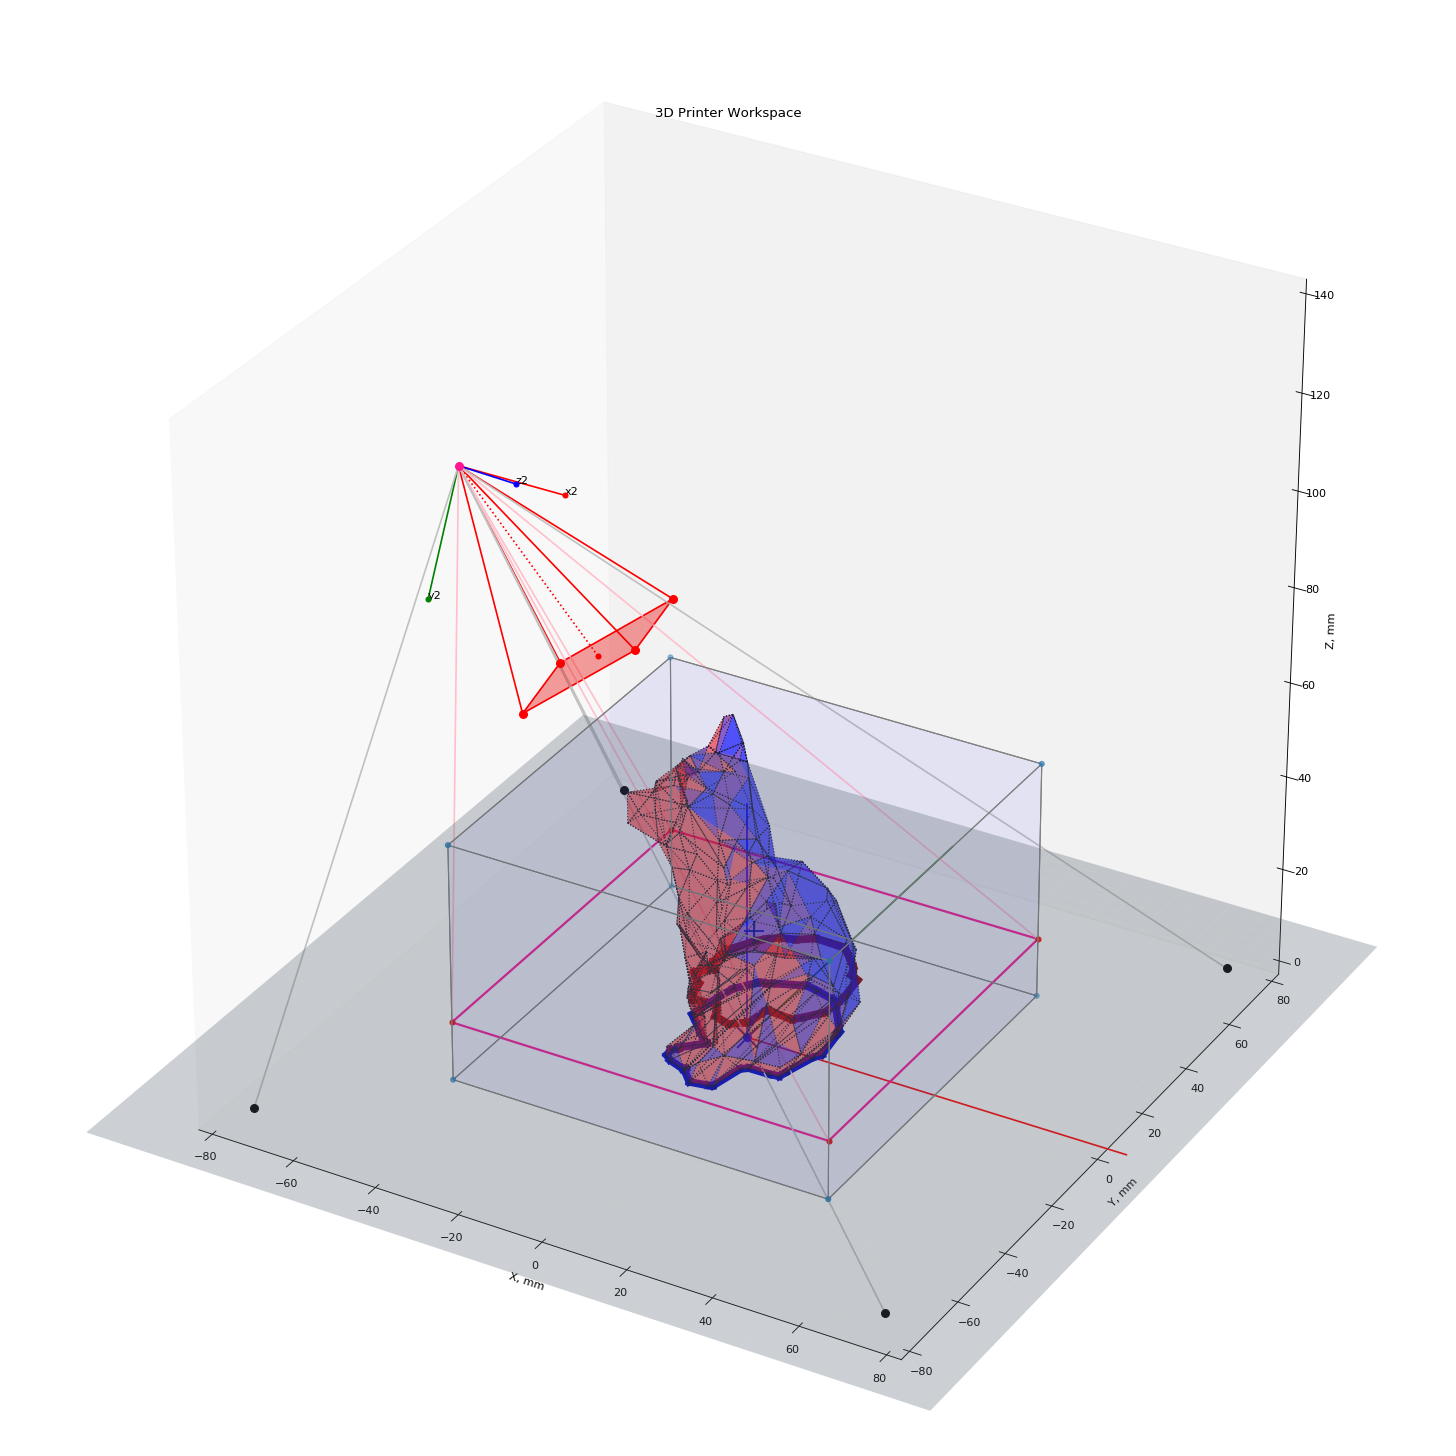

In [19]:
faces = Poly3DCollection(edges, linewidths=1, edgecolors='gray')
faces.set_facecolor((0,0,1,0.03))

fig = plt.figure(figsize=(18,18), dpi=80)
#ax = fig.add_subplot(111, projection='3d')
ax = Axes3D(fig)


# -------------------------------- Printing Bed
ax.plot_surface(xx_base,yy_base,zz_base, color='slategray', alpha=0.3)
ax.add_collection3d(faces)
ax.scatter(points[:,0], points[:,1], points[:,2], s=20)

# --------------------------------Origin
ax.plot([0,x_max_bed],[y*y_max_bed/img_size,y*y_max_bed/img_size],\
[z*z_max_bed/img_size,z*z_max_bed/img_size],color = 'r')
ax.plot([x*x_max_bed/img_size,x*x_max_bed/img_size],[0,y_max_bed],\
[z*z_max_bed/img_size,z*z_max_bed/img_size],color = 'g')
ax.plot([x*x_max_bed/img_size,x*x_max_bed/img_size],\
[y*y_max_bed/img_size,y*y_max_bed/img_size],[0,z_max_bed],color = 'b')
# --------------------------------End Origin

ax.scatter3D(x,y,z,color='b',s=50)

# --------------------------------Main Camera Location
#------------------------------------------------- Transformed Camera
ax.scatter(cam_main_tr[0][0],cam_main_tr[0][1],cam_main_tr[0][2],c='deeppink',s=50) # origin
#ax.text(cam_main_tr[0][0],cam_main_tr[0][1],cam_main_tr[0][2]+5,s='Camera',fontsize=10)
ax.scatter(cam_main_tr[1][0],cam_main_tr[1][1],cam_main_tr[1][2],c='r') # x2
ax.plot([cam_main_tr[0][0],cam_main_tr[1][0]],[cam_main_tr[0][1],cam_main_tr[1][1]],\
        [cam_main_tr[0][2],cam_main_tr[1][2]],c='r')
ax.text(cam_main_tr[1][0],cam_main_tr[1][1],cam_main_tr[1][2],s='x2',fontsize=10)

ax.scatter(cam_main_tr[2][0],cam_main_tr[2][1],cam_main_tr[2][2],c='g') # y2
ax.plot([cam_main_tr[0][0],cam_main_tr[2][0]],[cam_main_tr[0][1],cam_main_tr[2][1]],\
        [cam_main_tr[0][2],cam_main_tr[2][2]],c='g')
ax.text(cam_main_tr[2][0],cam_main_tr[2][1],cam_main_tr[2][2],s='y2',fontsize=10)

ax.scatter(cam_main_tr[3][0],cam_main_tr[3][1],cam_main_tr[3][2],c='b') # z2
ax.plot([cam_main_tr[0][0],cam_main_tr[3][0]],[cam_main_tr[0][1],cam_main_tr[3][1]],\
        [cam_main_tr[0][2],cam_main_tr[3][2]],c='b')
ax.text(cam_main_tr[3][0],cam_main_tr[3][1],cam_main_tr[3][2],s='z2',fontsize=10)

ax.plot([cam_main_tr[0][0],watch_tr[0]],[cam_main_tr[0][1],watch_tr[1]],[cam_main_tr[0][2],watch_tr[2]],':',c='r')

#------------------------------------------------- Transformed Watching distance
ax.scatter(watch_tr[0],watch_tr[1],watch_tr[2],marker='o',color='red',s=20)
ax.plot_surface(xx_tr,yy_tr,zz_tr,color='red', alpha=0.4)
#ax.text(watch_tr[0]+5,watch_tr[1],watch_tr[2],s='Frame',fontsize=10)

#------------------------------------------------- Transformed Frame
ax.scatter(xx_tr[0][0],yy_tr[0][0],zz_tr[0][0],color='r',s=50)
ax.scatter(xx_tr[-1][0],yy_tr[-1][0],zz_tr[-1][0],color='r',s=50)
ax.scatter(xx_tr[-1][-1],yy_tr[-1][-1],zz_tr[-1][-1],color='r',s=50)
ax.scatter(xx_tr[0][-1],yy_tr[0][-1],zz_tr[0][-1],color='r',s=50)

ax.plot([xx_tr[0][0],xx_tr[-1][0]],[yy_tr[0][0],yy_tr[-1][0]],[zz_tr[0][0],zz_tr[-1][0]],c='r')
ax.plot([xx_tr[-1][0],xx_tr[-1][-1]],[yy_tr[-1][0],yy_tr[-1][-1]],[zz_tr[-1][0],zz_tr[-1][-1]],c='r')
ax.plot([xx_tr[0][-1],xx_tr[-1][-1]],[yy_tr[0][-1],yy_tr[-1][-1]],[zz_tr[0][-1],zz_tr[-1][-1]],c='r')
ax.plot([xx_tr[0][-1],xx_tr[0][0]],[yy_tr[0][-1],yy_tr[0][0]],[zz_tr[0][-1],zz_tr[0][0]],c='r')

ax.plot([cam_main_tr[0][0],xx_tr[-1][0]],[cam_main_tr[0][1],yy_tr[-1][0]],[cam_main_tr[0][2],zz_tr[-1][0]],c='r')
ax.plot([cam_main_tr[0][0],xx_tr[0][-1]],[cam_main_tr[0][1],yy_tr[0][-1]],[cam_main_tr[0][2],zz_tr[0][-1]],c='r')
ax.plot([cam_main_tr[0][0],xx_tr[-1][-1]],[cam_main_tr[0][1],yy_tr[-1][-1]],[cam_main_tr[0][2],zz_tr[-1][-1]],c='r')
ax.plot([cam_main_tr[0][0],xx_tr[0][0]],[cam_main_tr[0][1],yy_tr[0][0]],[cam_main_tr[0][2],zz_tr[0][0]],c='r')


# -------------------------------- Slice
for i in range(np.shape(h_plane_1)[0]):
    ax.scatter(h_plane_1[i][0],h_plane_1[i][1],h_plane_1[i][2],c='red',marker='o',s=20)
    ax.plot([h_plane_1[i][0],h_plane_1[i-1][0]],[h_plane_1[i][1],h_plane_1[i-1][1]],\
            [h_plane_1[i][2],h_plane_1[i-1][2]],color='deeppink',linewidth=2)

for i in range(np.shape(visual_markers)[0]):
    ax.scatter(visual_markers[i][0],visual_markers[i][1],visual_markers[i][2],c='k',marker='o',s=50)
    #ax.plot([visual_markers[i][0],visual_markers[i-1][0]],[visual_markers[i][1],visual_markers[i-1][1]],\
            #[visual_markers[i][2],visual_markers[i-1][2]],color='k')
        
    
# ------------------------------------------------------add stl
#ax.add_collection3d(mplot3d.art3d.Poly3DCollection(mesh1.vectors,alpha=0.1,facecolor='b'))
#ax.add_collection3d(mplot3d.art3d.Line3DCollection(mesh1.vectors,alpha=0.3,linewidths=1,\
#                                                     color=[0.2,0.2,0.2],linestyle=':'))

for i in range(np.shape(mesh1.normals)[0]):
    if((np.dot(mesh1.normals[i],mesh1.vectors[i])[0])>0.0 and (np.dot(mesh1.normals[i],mesh1.vectors[i])[2])>0.0):
        ax.add_collection3d(mplot3d.art3d.Poly3DCollection(mesh1.vectors[i:i+1],alpha=0.4,facecolor='blue'))
    else:
        ax.add_collection3d(mplot3d.art3d.Poly3DCollection(mesh1.vectors[i:i+1],alpha=0.3,facecolor='red'))
        
ax.add_collection3d(mplot3d.art3d.Line3DCollection(mesh1.vectors,alpha=1,linewidths=1,\
color=[0.1,0.1,0.1],linestyle=':'))


# COG
ax.scatter(cog1[0],cog1[1],cog1[2],color='navy',marker='+',s=350)

ax.scatter(0,0,0,color='navy',marker='x',s=350)

for i in range(np.shape(P1[0])[0]):
    ax.scatter(P1[0][i][0],P1[0][i][1],P1[0][i][2],color='maroon',s=20)
    ax.plot([P1[0][i][0],P1[0][i-1][0]],[P1[0][i][1],P1[0][i-1][1]],[P1[0][i][2],P1[0][i-1][2]],\
            color='darkred',linewidth=7)
for i in range(np.shape(P0[0])[0]):
    ax.scatter(P0[0][i][0],P0[0][i][1],P0[0][i][2],color='darkblue',s=20)
    ax.plot([P0[0][i][0],P0[0][i-1][0]],[P0[0][i][1],P0[0][i-1][1]],[P0[0][i][2],P0[0][i-1][2]],\
            color='mediumblue',linewidth=7)

#ax.text(x_max_bed/2-15,y_max_bed/2-15,z_max_bed/2,s='STL Model',fontsize=10)
# -------------------------------------------------------end stl

# ------------------------------------------------------tracing
ax.plot([cam_main_tr[0][0],h_plane_1[0][0]],[cam_main_tr[0][1],h_plane_1[0][1]],\
        [cam_main_tr[0][2],h_plane_1[0][2]],color='pink')
ax.plot([cam_main_tr[0][0],h_plane_1[1][0]],[cam_main_tr[0][1],h_plane_1[1][1]],\
        [cam_main_tr[0][2],h_plane_1[1][2]],color='pink')
ax.plot([cam_main_tr[0][0],h_plane_1[2][0]],[cam_main_tr[0][1],h_plane_1[2][1]],\
        [cam_main_tr[0][2],h_plane_1[2][2]],color='pink')
ax.plot([cam_main_tr[0][0],h_plane_1[3][0]],[cam_main_tr[0][1],h_plane_1[3][1]],\
        [cam_main_tr[0][2],h_plane_1[3][2]],color='pink')

ax.plot([cam_main_tr[0][0],visual_markers[0][0]],[cam_main_tr[0][1],visual_markers[0][1]],\
        [cam_main_tr[0][2],visual_markers[0][2]],color='silver')
ax.plot([cam_main_tr[0][0],visual_markers[1][0]],[cam_main_tr[0][1],visual_markers[1][1]],\
        [cam_main_tr[0][2],visual_markers[1][2]],color='silver')
ax.plot([cam_main_tr[0][0],visual_markers[2][0]],[cam_main_tr[0][1],visual_markers[2][1]],\
        [cam_main_tr[0][2],visual_markers[2][2]],color='silver')
ax.plot([cam_main_tr[0][0],visual_markers[3][0]],[cam_main_tr[0][1],visual_markers[3][1]],\
        [cam_main_tr[0][2],visual_markers[3][2]],color='silver')
# ------------------------------------------------------end tracing


#ax.text(x_max_bed/2-15,y_max_bed/2-15,z_max_bed+5,s='Printing Volume',fontsize=10)
#ax.text(x_max_bed/2-5,y_max_bed/2+25,z_height-5,s='Top View',fontsize=10,color='deeppink')
#ax.text(75,75,3,s='Visual Markers',fontsize=10,color='k')
#ax.text(P0[0][0][0]+20,P0[0][0][1],3,s='Bottom Layer',fontsize=20,color='k')
#ax.text(P1[0][0][0]+20,P1[0][0][1],3,s='Printing Layer',fontsize=20,color='k')

ax.set_xlabel('X, mm')
ax.set_ylabel('Y, mm')
ax.set_zlabel('Z, mm')
ax.grid(False)
ax.set_xlim(-80,80)
ax.set_ylim(-80,80)
ax.set_zlim(0,140)
#ax.set_aspect(1)
ax.set_title('3D Printer Workspace')
plt.show()

In [20]:
# Get a Projection of the STL Slice

In [21]:
# STL slice
print('Slice: no of shapes = {}'.format(np.shape(P1)))
print('Shape 0: No of points = {}'.format(np.shape(P1[0])))
###print('Shape 1: No of points = {}'.format(np.shape(P1[1])))

#print('\nShape 0 = \n\n{}'.format(P1[0]))
###print('\nShape 1 = \n\n{}'.format(P1[1]))

# STL slice with additional dimension
# Shape P1[0]
Pc_0 = np.concatenate((P0[0], np.ones((np.shape(P0[0])[0],1), dtype=int)), axis=1)
Pc_1 = np.concatenate((P1[0], np.ones((np.shape(P1[0])[0],1), dtype=int)), axis=1)

Slice: no of shapes = (1, 43, 3)
Shape 0: No of points = (43, 3)


In [22]:
Pc_0_main = np.zeros((np.shape(P0[0])[0],4), dtype=float)
Pc_1_main = np.zeros((np.shape(P1[0])[0],4), dtype=float)


for i in range(np.shape(Pc_0)[0]):
    Pc_0_main[i] = np.dot(np.dot(la.inv(C),Pc_0[i]),V)
    Pc_0_main[i][0]=Pc_0_main[i][0]/Pc_0_main[i][3]
    Pc_0_main[i][1]=Pc_0_main[i][1]/Pc_0_main[i][3]
    Pc_0_main[i][2]=Pc_0_main[i][2]/Pc_0_main[i][3]
    
for i in range(np.shape(Pc_1)[0]):
    Pc_1_main[i] = np.dot(np.dot(la.inv(C),Pc_1[i]),V)
    Pc_1_main[i][0]=Pc_1_main[i][0]/Pc_1_main[i][3]
    Pc_1_main[i][1]=Pc_1_main[i][1]/Pc_1_main[i][3]
    Pc_1_main[i][2]=Pc_1_main[i][2]/Pc_1_main[i][3]


Pc_0_pic = np.zeros((np.shape(P0[0])[0],3), dtype=float)
Pc_1_pic = np.zeros((np.shape(P1[0])[0],3), dtype=float)
    
for i in range(np.shape(Pc_0_pic)[0]):
    Pc_0_pic[i] = np.dot(cam_mtx,Pc_0_main[i,0:3])
    Pc_0_pic[i][0]=Pc_0_pic[i][0]/Pc_0_pic[i][2]
    Pc_0_pic[i][1]=Pc_0_pic[i][1]/Pc_0_pic[i][2]
    
for i in range(np.shape(Pc_1_pic)[0]):
    Pc_1_pic[i] = np.dot(cam_mtx,Pc_1_main[i,0:3])
    Pc_1_pic[i][0]=Pc_1_pic[i][0]/Pc_1_pic[i][2]
    Pc_1_pic[i][1]=Pc_1_pic[i][1]/Pc_1_pic[i][2]

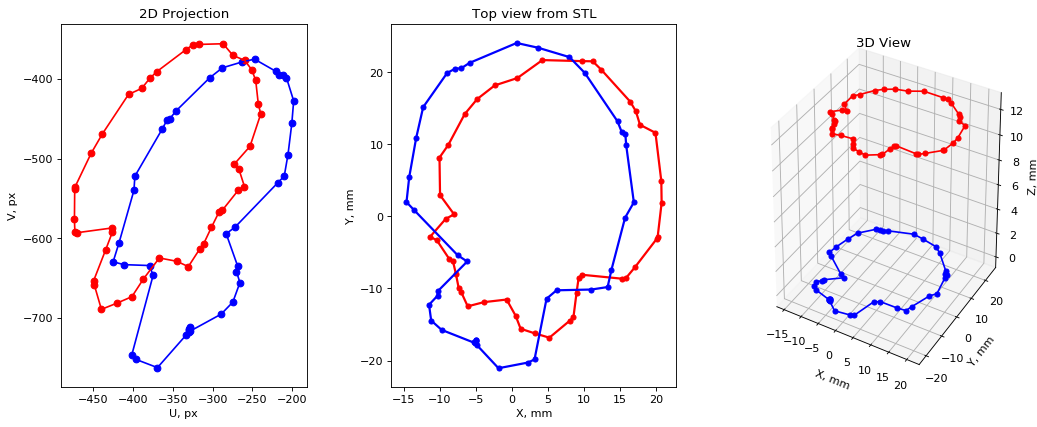

In [23]:
fig = plt.figure(figsize=(16,6), dpi=80)

ax = fig.add_subplot(131)
#--------------------------- P0[0]
for i in range(np.shape(P0[0])[0]):
    ax.scatter(Pc_0_pic[i][0],Pc_0_pic[i][1], label='shape 0', color='b')
    ax.plot([Pc_0_pic[i][0],Pc_0_pic[i-1][0]],[Pc_0_pic[i][1],Pc_0_pic[i-1][1]],color='b')
#--------------------------- P1[0]
for i in range(np.shape(P1[0])[0]):
    ax.scatter(Pc_1_pic[i][0],Pc_1_pic[i][1], label='shape 1', color='r')
    ax.plot([Pc_1_pic[i][0],Pc_1_pic[i-1][0]],[Pc_1_pic[i][1],Pc_1_pic[i-1][1]],color='r')
ax.set_xlabel('U, px')
ax.set_ylabel('V, px')
#ax.grid(False)
#ax.set_xlim(-100,100)
#ax.set_ylim(-800,-300)
ax.set_aspect(1)
ax.set_title('2D Projection')

ax = fig.add_subplot(132)
for i in range(np.shape(P1[0])[0]):
    ax.scatter(P1[0][i][0],P1[0][i][1],color='red',s=20)
    ax.plot([P1[0][i][0],P1[0][i-1][0]],[P1[0][i][1],P1[0][i-1][1]],color='red',linewidth=2)
for i in range(np.shape(P0[0])[0]):
    ax.scatter(P0[0][i][0],P0[0][i][1],color='blue',s=20)
    ax.plot([P0[0][i][0],P0[0][i-1][0]],[P0[0][i][1],P0[0][i-1][1]],color='blue',linewidth=2)
ax.set_xlabel('X, mm')
ax.set_ylabel('Y, mm')
ax.set_aspect(1)
ax.set_title('Top view from STL')

ax = fig.add_subplot(133,projection='3d')
for i in range(np.shape(P0[0])[0]):
    ax.scatter(P0[0][i][0],P0[0][i][1],P0[0][i][2],color='b')
    ax.plot([P0[0][i][0],P0[0][i-1][0]],[P0[0][i][1],P0[0][i-1][1]],[P0[0][i][2],P0[0][i-1][2]],color='blue')
for i in range(np.shape(P1[0])[0]):
    ax.scatter(P1[0][i][0],P1[0][i][1],P1[0][i][2],color='r')
    ax.plot([P1[0][i][0],P1[0][i-1][0]],[P1[0][i][1],P1[0][i-1][1]],[P1[0][i][2],P1[0][i-1][2]],color='red')
ax.set_xlabel('X, mm')
ax.set_ylabel('Y, mm')
ax.set_zlabel('Z, mm')
ax.set_title('3D View')

plt.show()

In [24]:
# Project G-Code / STL on image

In [25]:
# Image Projection
# find cam transform
# Based on 4 Visual Markers

#2D image points, [pixels]
image_points = np.array([
                            (391, 221),
                            (788, 77),
                            (1031, 368),
                            (569, 562),
                        ], dtype="double")
 
# 3D model points, [mm]
model_points = np.array([
                            (-44.0, -44.0, 0.0),
                            (-44.0, 44.0, 0.0),
                            (44.0, 44.0, 0.0),
                            (44.0, -44.0, 0.0)
                            ])

src = cv2.imread('dataset/rect_full/rect_L33.jpg')
LAYER_NUMBER = 33
img = src.copy()

In [26]:
dist_coeffs = np.zeros((4,1)) # Assuming no lens distortion
(success, rotation_vector, translation_vector) = cv2.solvePnP(model_points, image_points,\
                                            camera_intrinsic_K, dist_coeffs,flags=cv2.cv2.SOLVEPNP_ITERATIVE)
 
#print("Rotation Vector:\n {}".format(rotation_vector))
#print("Translation Vector:\n {}".format(translation_vector))

In [27]:
# Object rotation

otheta_x = 0.0 # degrees
otheta_y = 0.0 # degrees
#otheta_z = 170.0 # degrees

ot_x = -2.3
ot_y = 3.2
ot_z = 0.0

otheta_z = 169.0 # degrees

### vertical shift ot_x is layer dependend
### the experimental equation: ot_x = LAYER_NUMBER * 3/172 - 617/215
### references: L4 -> ot_x=-2.8    L40 -> ot_x=-2.2    L90 -> ot_x=-1.3
#ot_x = LAYER_NUMBER * 3/172 - 617/215
#ot_y = 3.2 ### default value for all layers
#ot_y = LAYER_NUMBER * (-1/325) + 42/13
ot_z = 0.0

oRx = np.array([[1,0,0],[0,np.cos(otheta_x*np.pi/180),-np.sin(otheta_x*np.pi/180)],\
               [0,np.sin(otheta_x*np.pi/180),np.cos(otheta_x*np.pi/180)]]) # rotation around x
oRy = np.array([[np.cos(otheta_y*np.pi/180),0,np.sin(otheta_y*np.pi/180)],[0,1,0],\
               [-np.sin(otheta_y*np.pi/180),0,np.cos(otheta_y*np.pi/180)]]) # rotation around x
oRz = np.array([[np.cos(otheta_z*np.pi/180),-np.sin(otheta_z*np.pi/180),0],\
               [np.sin(otheta_z*np.pi/180),np.cos(otheta_z*np.pi/180),0],[0,0,1]]) # rotation around x

oR = np.dot(np.dot(oRx,oRy),oRz)
ot = np.array([ot_x,ot_y,ot_z])

#print('oRx = \n{}\n'.format(oRx))
#print('oRy = \n{}\n'.format(oRy))
#print('oRz = \n{}\n'.format(oRz))
#print('\noR = \n{}\n'.format(oR))

#print('\not = \n{}\n'.format(ot.T))

H = np.zeros((4,4), dtype=float)
H[0:3,0:3] = oR
H[0:3,3] = ot.T
H[3,3] = 1

#print('\nH = \n{}\n'.format(H))

In [28]:
# STL slice with additional dimension
# Shape P1[0]
Pc_0 = np.concatenate((P0[0], np.ones((np.shape(P0[0])[0],1), dtype=int)), axis=1)
Pc_1 = np.concatenate((P1[0], np.ones((np.shape(P1[0])[0],1), dtype=int)), axis=1)

Pc_0_main = np.zeros((np.shape(P0[0])[0],4), dtype=float)
Pc_1_main = np.zeros((np.shape(P1[0])[0],4), dtype=float)

for i in range(np.shape(Pc_0)[0]):
    Pc_0_main[i] = np.dot(H,Pc_0[i])
for i in range(np.shape(Pc_1)[0]):
    Pc_1_main[i] = np.dot(H,Pc_1[i])
    
tcP0 = cv2.projectPoints(np.asarray(Pc_0_main[:,0:3],dtype=np.float32),rotation_vector,\
                         translation_vector,camera_intrinsic_K,dist_coeffs)[0].reshape(-1, 2)
tcP1 = cv2.projectPoints(np.asarray(Pc_1_main[:,0:3],dtype=np.float32),rotation_vector,\
                         translation_vector,camera_intrinsic_K,dist_coeffs)[0].reshape(-1, 2)

In [29]:
# gcode info:

# layer number

# TYPE:WALL-OUTER          -- 1
# TYPE:WALL-INNER          -- 2
# TYPE:FILL                -- 3
# TYPE:SUPPORT             -- 4
# TYPE:SUPPORT-INTERFACE   -- 5


word_bank  = []
layer_bank = [] # just a number of layer
type_bank = []
line_bank = []
parsed_Num_of_layers = 0
gcode_type = 0

#with open('fox/70mm_fox.gcode', 'r') as fh:
with open('misc_data/70mm_low_poly_fox_MatterControl.gcode', 'r') as fh:
    for line_text in fh.readlines():
        line = Line(line_text) # all lines in file
        # print(line)
        w = line.block.words # splits blocks into XYZEF, omits comments
        # print(w)
        if(np.shape(w)[0] == 0): # if line is empty, i.e. comment line -> then skip it
            pass
        else:
            word_bank.append(w) # <Word: G01>, <Word: X15.03>, <Word: Y9.56>, <Word: Z0.269>, ...
            # print(word_bank) # does not process comments
            layer_bank.append(parsed_Num_of_layers)
            type_bank.append(gcode_type)
            line_bank.append(line_text)
            # np.shape(layer_bank) = np.shape(word_bank) = np.shape(line_bank) = len(layer_bank)
            #print(layer_bank)
            # line_bank[0] = 'G21 ; set units to millimeters\n'
            # all lines in file
        if line.comment:
            #print(line.comment)
            if (line.comment.text[0:6] == "LAYER:"):
                parsed_Num_of_layers = parsed_Num_of_layers + 1
                gcode_type = 0
            if line.comment:
                if (line.comment.text[0:15] == "TYPE:WALL-OUTER"):
                    #print("TYPE:WALL-OUTER")
                    gcode_type = 1
                if (line.comment.text[0:15] == "TYPE:WALL-INNER"):
                    #print("TYPE:WALL-INNER")
                    gcode_type = 2
                if (line.comment.text[0:9] == "TYPE:FILL"):
                    #print("TYPE:FILL")
                    gcode_type = 3
                if (line.comment.text[0:12] == "TYPE:SUPPORT"):
                    #print("TYPE:SUPPORT")
                    gcode_type = 4
                if (line.comment.text[0:22] == "TYPE:SUPPORT-INTERFACE"):
                    #print("TYPE:SUPPORT-INTERFACE")
                    gcode_type = 5
                
print(parsed_Num_of_layers)


175


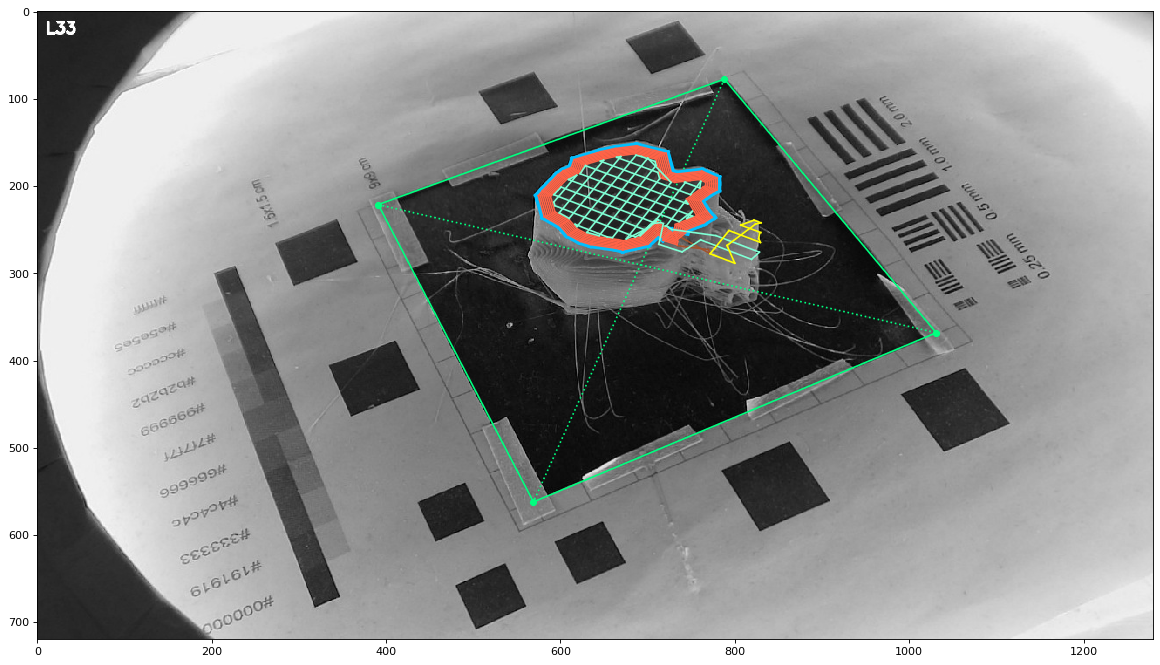

In [30]:
fig = plt.figure(figsize=(18,14), dpi=80)
plt.imshow(img)

plt.scatter(391,221,c='springgreen',s=30)
plt.scatter(788,77,c='springgreen',s=30)
plt.scatter(1031,368,c='springgreen',s=30)
plt.scatter(569,562,c='springgreen',s=30)

plt.plot([391,788],[221,77],c='springgreen')
plt.plot([788,1031],[77,368],c='springgreen')
plt.plot([1031,569],[368,562],c='springgreen')
plt.plot([569,391],[562,221],c='springgreen')

plt.plot([391,1031],[221,368],c='springgreen',linestyle=':')
plt.plot([788,569],[77,562],c='springgreen',linestyle=':')

#plt.scatter(743,212,c='yellow',marker='X',s=100)

# for k in [6,8,70]: # layers
for k in [33-2]: # layers
    command_bank = []
    line_command_bank = []
    gcode_line_number = 0
    
    X_active_bank = []
    Y_active_bank = []
    Z_active_bank = []
    G_active_bank = []
    E_active_bank = []
    F_active_bank = []

    idx = []
    
    X_active_default = []; X_active_wall_outer = []; X_active_wall_inner = []
    Y_active_default = []; Y_active_wall_outer = []; Y_active_wall_inner = []
    Z_active_default = []; Z_active_wall_outer = []; Z_active_wall_inner = []
    G_active_default = []; G_active_wall_outer = []; G_active_wall_inner = []
    E_active_default = []; E_active_wall_outer = []; E_active_wall_inner = []
    F_active_default = []; F_active_wall_outer = []; F_active_wall_inner = []

    X_active_fill = []; X_active_support = []; X_active_support_interface = []
    Y_active_fill = []; Y_active_support = []; Y_active_support_interface = []
    Z_active_fill = []; Z_active_support = []; Z_active_support_interface = []
    G_active_fill = []; G_active_support = []; G_active_support_interface = []
    E_active_fill = []; E_active_support = []; E_active_support_interface = []
    F_active_fill = []; F_active_support = []; F_active_support_interface = []
    
    for i in range(len(layer_bank)): # for each line in file
        if (layer_bank[i] == k):
            idx.append(i)
            line_command_bank.append(line_bank[i])
            # line_command_bank = all gcode for the specific layer without comments
            for j in range(len(word_bank[i])):
                command_bank.append(str(word_bank[i][j]))
                if (str(word_bank[i][j])[:1] == 'G'):
                    G_active_bank.append(float(str(word_bank[i][j])[1:]))
                if (str(word_bank[i][j])[:1] == 'X'):
                    X_active_bank.append(float(str(word_bank[i][j])[1:]))
                if (str(word_bank[i][j])[:1] == 'Y'):
                    Y_active_bank.append(float(str(word_bank[i][j])[1:]))
                if (str(word_bank[i][j])[:1] == 'Z'):
                    Z_active_bank.append(float(str(word_bank[i][j])[1:]))
                if (str(word_bank[i][j])[:1] == 'E'):
                    E_active_bank.append(float(str(word_bank[i][j])[1:]))
                if (str(word_bank[i][j])[:1] == 'F'):
                    F_active_bank.append(float(str(word_bank[i][j])[1:]))

    for m in range(len(X_active_bank)):
        if(type_bank[np.min(idx)+m] == 0):
            X_active_default.append(X_active_bank[m])
            Y_active_default.append(Y_active_bank[m])
            Z_active_default.append(Z_active_bank[m])
        if(type_bank[np.min(idx)+m] == 1):
            X_active_wall_outer.append(X_active_bank[m])
            Y_active_wall_outer.append(Y_active_bank[m])
            Z_active_wall_outer.append(Z_active_bank[m])
        if(type_bank[np.min(idx)+m] == 2):
            X_active_wall_inner.append(X_active_bank[m])
            Y_active_wall_inner.append(Y_active_bank[m])
            Z_active_wall_inner.append(Z_active_bank[m])
        if(type_bank[np.min(idx)+m] == 3):
            X_active_fill.append(X_active_bank[m])
            Y_active_fill.append(Y_active_bank[m])
            Z_active_fill.append(Z_active_bank[m])
        if(type_bank[np.min(idx)+m] == 4):
            X_active_support.append(X_active_bank[m])
            Y_active_support.append(Y_active_bank[m])
            Z_active_support.append(Z_active_bank[m])
        if(type_bank[np.min(idx)+m] == 5):
            X_active_support_interface.append(X_active_bank[m])
            Y_active_support_interface.append(Y_active_bank[m])
            Z_active_support_interface.append(Z_active_bank[m])

            
    G_default = np.zeros((np.shape(X_active_default)[0],4),dtype=np.float32)
    G_wall_outer = np.zeros((np.shape(X_active_wall_outer)[0],4),dtype=np.float32)
    G_wall_inner = np.zeros((np.shape(X_active_wall_inner)[0],4),dtype=np.float32)
    G_fill = np.zeros((np.shape(X_active_fill)[0],4),dtype=np.float32)
    G_support = np.zeros((np.shape(X_active_support)[0],4),dtype=np.float32)
    G_support_interface = np.zeros((np.shape(X_active_support_interface)[0],4),dtype=np.float32)

    G_default[:,0] = X_active_default
    G_default[:,1] = Y_active_default
    G_default[:,2] = Z_active_default
    G_default[:,3] = np.ones((1,np.shape(X_active_default)[0]),dtype=np.float32)

    G_wall_outer[:,0] = X_active_wall_outer
    G_wall_outer[:,1] = Y_active_wall_outer
    G_wall_outer[:,2] = Z_active_wall_outer
    G_wall_outer[:,3] = np.ones((1,np.shape(X_active_wall_outer)[0]),dtype=np.float32)

    G_wall_inner[:,0] = X_active_wall_inner
    G_wall_inner[:,1] = Y_active_wall_inner
    G_wall_inner[:,2] = Z_active_wall_inner
    G_wall_inner[:,3] = np.ones((1,np.shape(X_active_wall_inner)[0]),dtype=np.float32)

    G_fill[:,0] = X_active_fill
    G_fill[:,1] = Y_active_fill
    G_fill[:,2] = Z_active_fill
    G_fill[:,3] = np.ones((1,np.shape(X_active_fill)[0]),dtype=np.float32)

    G_support[:,0] = X_active_support
    G_support[:,1] = Y_active_support
    G_support[:,2] = Z_active_support
    G_support[:,3] = np.ones((1,np.shape(X_active_support)[0]),dtype=np.float32)

    G_support_interface[:,0] = X_active_support_interface
    G_support_interface[:,1] = Y_active_support_interface
    G_support_interface[:,2] = Z_active_support_interface
    G_support_interface[:,3] = np.ones((1,np.shape(X_active_support_interface)[0]),dtype=np.float32)
    
    tG_default = np.zeros((np.shape(G_default)[0],4), dtype=np.float32)
    tG_wall_outer = np.zeros((np.shape(G_wall_outer)[0],4), dtype=np.float32)
    tG_wall_inner = np.zeros((np.shape(G_wall_inner)[0],4), dtype=np.float32)
    tG_fill = np.zeros((np.shape(G_fill)[0],4), dtype=np.float32)
    tG_support = np.zeros((np.shape(G_support)[0],4), dtype=np.float32)
    tG_support_interface = np.zeros((np.shape(G_support_interface)[0],4), dtype=np.float32)
    
    for i in range(np.shape(G_default)[0]):
        tG_default[i] = np.dot(H,G_default[i])
    for i in range(np.shape(G_wall_outer)[0]):
        tG_wall_outer[i] = np.dot(H,G_wall_outer[i])
    for i in range(np.shape(G_wall_inner)[0]):
        tG_wall_inner[i] = np.dot(H,G_wall_inner[i])
    for i in range(np.shape(G_fill)[0]):
        tG_fill[i] = np.dot(H,G_fill[i])
    for i in range(np.shape(G_support)[0]):
        tG_support[i] = np.dot(H,G_support[i])
    for i in range(np.shape(G_support_interface)[0]):
        tG_support_interface[i] = np.dot(H,G_support_interface[i])
        
        
    tGp_default = cv2.projectPoints(np.asarray(tG_default[:,0:3],dtype=float),rotation_vector,\
                        translation_vector,camera_intrinsic_K,dist_coeffs)[0].reshape(-1, 2)
    tGp_wall_outer = cv2.projectPoints(np.asarray(tG_wall_outer[:,0:3],dtype=float),rotation_vector,\
                        translation_vector,camera_intrinsic_K,dist_coeffs)[0].reshape(-1, 2)
    tGp_wall_inner = cv2.projectPoints(np.asarray(tG_wall_inner[:,0:3],dtype=float),rotation_vector,\
                        translation_vector,camera_intrinsic_K,dist_coeffs)[0].reshape(-1, 2)
    tGp_fill = cv2.projectPoints(np.asarray(tG_fill[:,0:3],dtype=float),rotation_vector,\
                        translation_vector,camera_intrinsic_K,dist_coeffs)[0].reshape(-1, 2)

    tGp_support = cv2.projectPoints(np.asarray(tG_support[:,0:3],dtype=float),rotation_vector,\
                        translation_vector,camera_intrinsic_K,dist_coeffs)[0].reshape(-1, 2)
    #tGp_support_interface = cv2.projectPoints(np.asarray(tG_support_interface[:,0:3],dtype=float),rotation_vector,\
                        #translation_vector,camera_intrinsic_K,dist_coeffs)[0].reshape(-1, 2)
        
        
    for i in range(np.shape(tGp_default)[0]):
        plt.plot([tGp_default[i][0],tGp_default[i-1][0]],[tGp_default[i][1],tGp_default[i-1][1]],color='sienna')
    for i in range(np.shape(tGp_wall_outer)[0]):
        plt.plot([tGp_wall_outer[i][0],tGp_wall_outer[i-1][0]],\
             [tGp_wall_outer[i][1],tGp_wall_outer[i-1][1]],color='deepskyblue',linewidth=4)
    for i in range(np.shape(tGp_wall_inner)[0]):
        plt.plot([tGp_wall_inner[i][0],tGp_wall_inner[i-1][0]],\
                 [tGp_wall_inner[i][1],tGp_wall_inner[i-1][1]],color='tomato')
    for i in range(np.shape(tGp_fill)[0]):
        plt.plot([tGp_fill[i][0],tGp_fill[i-1][0]],[tGp_fill[i][1],tGp_fill[i-1][1]],color='aquamarine')
    for i in range(np.shape(tGp_support)[0]):
        plt.plot([tGp_support[i][0],tGp_support[i-1][0]],[tGp_support[i][1],tGp_support[i-1][1]],color='yellow')
           
'''for i in range(np.shape(tcP0)[0]):
    plt.plot([tcP0[i][0],tcP0[i-1][0]],[tcP0[i][1],tcP0[i-1][1]],color='blue',linewidth=3)
        
for i in range(np.shape(tcP1)[0]):
    plt.plot([tcP1[i][0],tcP1[i-1][0]],[tcP1[i][1],tcP1[i-1][1]],color='red',linewidth=3)'''
    
plt.show()

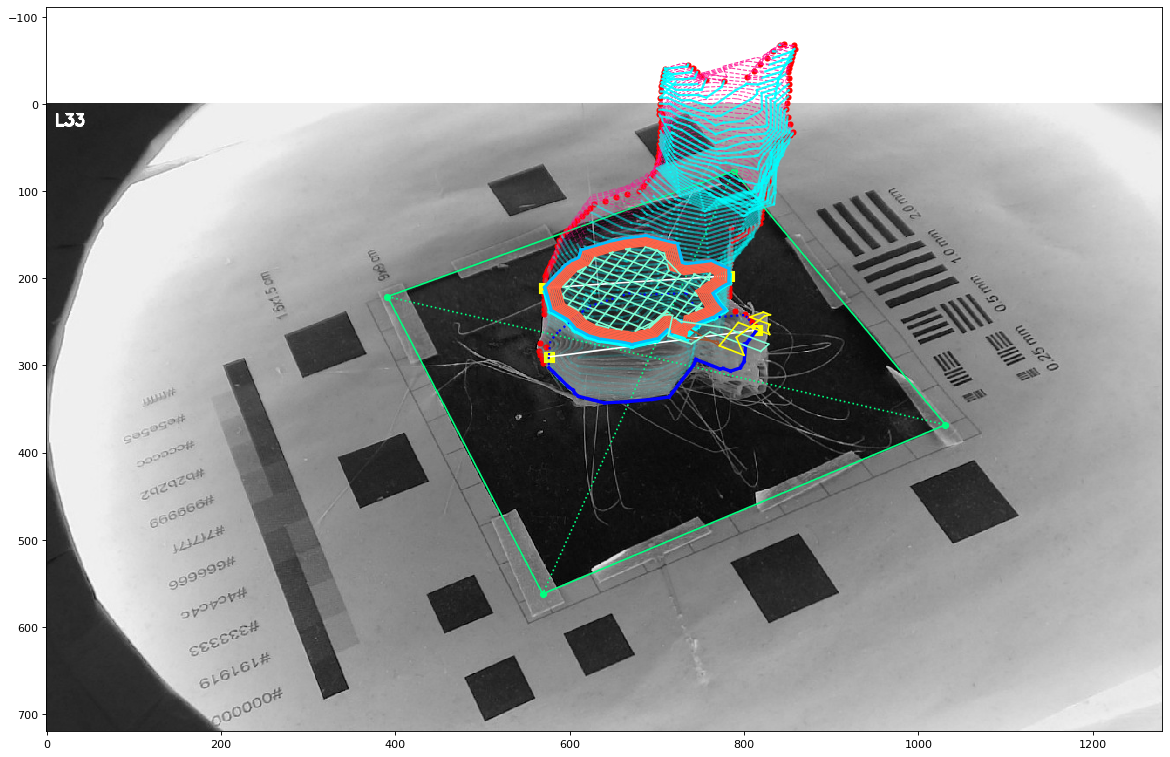

In [31]:
fig = plt.figure(figsize=(18,14), dpi=80)
plt.imshow(img)

plt.scatter(391,221,c='springgreen',s=30)
plt.scatter(788,77,c='springgreen',s=30)
plt.scatter(1031,368,c='springgreen',s=30)
plt.scatter(569,562,c='springgreen',s=30)

plt.plot([391,788],[221,77],c='springgreen')
plt.plot([788,1031],[77,368],c='springgreen')
plt.plot([1031,569],[368,562],c='springgreen')
plt.plot([569,391],[562,221],c='springgreen')

plt.plot([391,1031],[221,368],c='springgreen',linestyle=':')
plt.plot([788,569],[77,562],c='springgreen',linestyle=':')

#plt.scatter(743,212,c='yellow',marker='X',s=100)

# whole model
for jj in range(0,int(part_height),1):
    sl = meshcut.cross_section_mesh(mesh_plane,meshcut.Plane((0, 0, jj), (0, 0, 1)))
    
    for m in range(np.shape(sl)[0]):
        Pc = np.concatenate((sl[m], np.ones((np.shape(sl[m])[0],1), dtype=int)), axis=1)
        Pc_main = np.zeros((np.shape(sl[m])[0],4), dtype=float)
        for f in range(np.shape(Pc)[0]):
            Pc_main[f] = np.dot(H,Pc[f])
        tcP = cv2.projectPoints(np.asarray(Pc_main[:,0:3],dtype=np.float32),rotation_vector,\
                         translation_vector,camera_intrinsic_K,dist_coeffs)[0].reshape(-1, 2)
        # visibility check
        # Solve the system of equations 
        # xmin * k + 1 * b = ymin and 
        # xmax * k + 1 * b = ymax:
        eq_coeffs = np.array([[np.min(tcP[:,0]),1], [np.max(tcP[:,0]),1]])
        eq_answers = np.array([tcP[np.argmin(tcP[:,0])][1],tcP[np.argmax(tcP[:,0])][1]])
        slope = np.linalg.solve(eq_coeffs, eq_answers)[0]
        shift = np.linalg.solve(eq_coeffs, eq_answers)[1]
        
        #plt.plot([np.min(tcP[:,0]),np.max(tcP[:,0])],\
                 #[tcP[np.argmin(tcP[:,0])][1],tcP[np.argmax(tcP[:,0])][1]],c='cyan',linewidth=1,linestyle='-')
        plt.scatter(np.min(tcP[:,0]),tcP[np.argmin(tcP[:,0])][1],s=20,c='r')
        plt.scatter(np.max(tcP[:,0]),tcP[np.argmax(tcP[:,0])][1],s=20,c='r')
        
        for b in range(np.shape(sl[m])[0]):
            if(tcP[b][1] > slope*tcP[b][0]+shift):
                plt.plot([tcP[b][0],tcP[b-1][0]],[tcP[b][1],tcP[b-1][1]],\
                         color='cyan',alpha=jj/70,linewidth=2,linestyle='-')
            else:
                plt.plot([tcP[b][0],tcP[b-1][0]],[tcP[b][1],tcP[b-1][1]],\
                         color='deeppink',alpha=jj/70,linewidth=1,linestyle='--')
            #plt.plot([tcP[b][0],tcP[b-1][0]],[tcP[b][1],tcP[b-1][1]],color='deeppink')

# First and last layers
#for i in range(np.shape(tcP0)[0]):
#    plt.plot([tcP0[i][0],tcP0[i-1][0]],[tcP0[i][1],tcP0[i-1][1]],color='blue',linewidth=3)

    
plt.plot([np.min(tcP1[:,0]),np.max(tcP1[:,0])],[tcP1[np.argmin(tcP1[:,0])][1],tcP1[np.argmax(tcP1[:,0])][1]],c='white')
plt.plot([np.min(tcP0[:,0]),np.max(tcP0[:,0])],[tcP0[np.argmin(tcP0[:,0])][1],tcP0[np.argmax(tcP0[:,0])][1]],c='white')
plt.scatter(np.min(tcP1[:,0]),tcP1[np.argmin(tcP1[:,0])][1],color='yellow',marker='s',s=70)
plt.scatter(np.max(tcP1[:,0]),tcP1[np.argmax(tcP1[:,0])][1],color='yellow',marker='s',s=70)

plt.scatter(np.min(tcP0[:,0]),tcP0[np.argmin(tcP0[:,0])][1],color='yellow',marker='s',s=70)
plt.scatter(np.max(tcP0[:,0]),tcP0[np.argmax(tcP0[:,0])][1],color='yellow',marker='s',s=70)

# Solve the system of equations 
# xmin * k + 1 * b = ymin and 
# xmax * k + 1 * b = ymax:

eq_coeffs = np.array([[np.min(tcP1[:,0]),1], [np.max(tcP1[:,0]),1]])
eq_answers = np.array([tcP1[np.argmin(tcP1[:,0])][1],tcP1[np.argmax(tcP1[:,0])][1]])

slope = np.linalg.solve(eq_coeffs, eq_answers)[0]
shift = np.linalg.solve(eq_coeffs, eq_answers)[1]


xx = []
yy = []
yy5 = []
i=0
for i in range(np.shape(tcP1)[0]):
    if(tcP1[i][1] > slope*tcP1[i][0]+shift):
        plt.plot([tcP1[i][0],tcP1[i-1][0]],[tcP1[i][1],tcP1[i-1][1]],color='cyan',linewidth=5)
        xx.append(tcP1[i][0])
        yy.append(tcP1[i][1]-20)
        yy5.append(tcP1[i][1]+40)
    else:
        plt.plot([tcP1[i][0],tcP1[i-1][0]],[tcP1[i][1],tcP1[i-1][1]],linestyle=':',color='red',linewidth=2)
        
        
# Solve the system of equations 
# xmin * k + 1 * b = ymin and 
# xmax * k + 1 * b = ymax:

eq_coeffs = np.array([[np.min(tcP0[:,0]),1], [np.max(tcP0[:,0]),1]])
eq_answers = np.array([tcP0[np.argmin(tcP0[:,0])][1],tcP0[np.argmax(tcP0[:,0])][1]])

slope = np.linalg.solve(eq_coeffs, eq_answers)[0]
shift = np.linalg.solve(eq_coeffs, eq_answers)[1]

for i in range(np.shape(tcP0)[0]):
    if(tcP0[i][1] > slope*tcP0[i][0]+shift):
        plt.plot([tcP0[i][0],tcP0[i-1][0]],[tcP0[i][1],tcP0[i-1][1]],color='blue',linewidth=3)
    else:
        plt.plot([tcP0[i][0],tcP0[i-1][0]],[tcP0[i][1],tcP0[i-1][1]],linestyle=':',color='blue',linewidth=2)
        
        
for i in range(np.shape(tGp_default)[0]):
    plt.plot([tGp_default[i][0],tGp_default[i-1][0]],[tGp_default[i][1],tGp_default[i-1][1]],color='sienna')
for i in range(np.shape(tGp_wall_outer)[0]):
    plt.plot([tGp_wall_outer[i][0],tGp_wall_outer[i-1][0]],\
             [tGp_wall_outer[i][1],tGp_wall_outer[i-1][1]],color='deepskyblue',linewidth=4)
for i in range(np.shape(tGp_wall_inner)[0]):
    plt.plot([tGp_wall_inner[i][0],tGp_wall_inner[i-1][0]],\
                 [tGp_wall_inner[i][1],tGp_wall_inner[i-1][1]],color='tomato')
for i in range(np.shape(tGp_fill)[0]):
    plt.plot([tGp_fill[i][0],tGp_fill[i-1][0]],[tGp_fill[i][1],tGp_fill[i-1][1]],color='aquamarine')
for i in range(np.shape(tGp_support)[0]):
    plt.plot([tGp_support[i][0],tGp_support[i-1][0]],[tGp_support[i][1],tGp_support[i-1][1]],color='yellow')
        
        
plt.show()

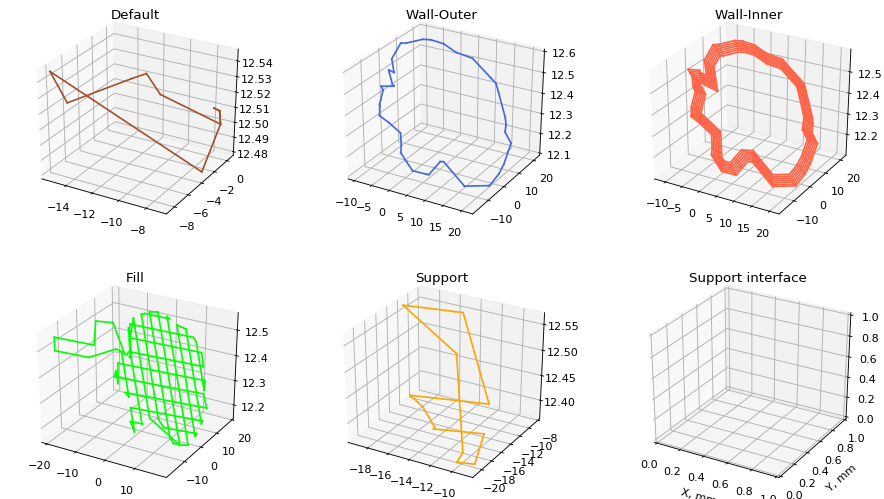

In [32]:
fig = plt.figure(figsize=(14, 8), dpi=80)
ax = fig.add_subplot(231, projection='3d')
for i in range(len(X_active_default)):
    ax.plot([X_active_default[i],X_active_default[i-1]],
        [Y_active_default[i],Y_active_default[i-1]],
        [Z_active_default[i],Z_active_default[i-1]],color='sienna')
ax.set_title('Default')

ax = fig.add_subplot(232, projection='3d')
for i in range(len(X_active_wall_outer)):
    ax.plot([X_active_wall_outer[i],X_active_wall_outer[i-1]],
        [Y_active_wall_outer[i],Y_active_wall_outer[i-1]],
        [Z_active_wall_outer[i],Z_active_wall_outer[i-1]],color='royalblue')
ax.set_title('Wall-Outer')

ax = fig.add_subplot(233, projection='3d')
for i in range(len(X_active_wall_inner)):
    ax.plot([X_active_wall_inner[i],X_active_wall_inner[i-1]],
        [Y_active_wall_inner[i],Y_active_wall_inner[i-1]],
        [Z_active_wall_inner[i],Z_active_wall_inner[i-1]],color='tomato')
ax.set_title('Wall-Inner')

ax = fig.add_subplot(234, projection='3d')
for i in range(len(X_active_fill)):
    ax.plot([X_active_fill[i],X_active_fill[i-1]],
        [Y_active_fill[i],Y_active_fill[i-1]],
        [Z_active_fill[i],Z_active_fill[i-1]],color='lime')
ax.set_title('Fill')

ax = fig.add_subplot(235, projection='3d')
for i in range(len(X_active_support)):
    ax.plot([X_active_support[i],X_active_support[i-1]],
        [Y_active_support[i],Y_active_support[i-1]],
        [Z_active_support[i],Z_active_support[i-1]],color='orange')
ax.set_title('Support')

ax = fig.add_subplot(236, projection='3d')
for i in range(len(X_active_support_interface)):
    ax.plot([X_active_support_interface[i],X_active_support_interface[i-1]],
        [Y_active_support_interface[i],Y_active_support_interface[i-1]],
        [Z_active_support_interface[i],Z_active_support_interface[i-1]],color='cyan')
ax.set_title('Support interface')
ax.set_xlabel('X, mm')
ax.set_ylabel('Y, mm')
plt.show()

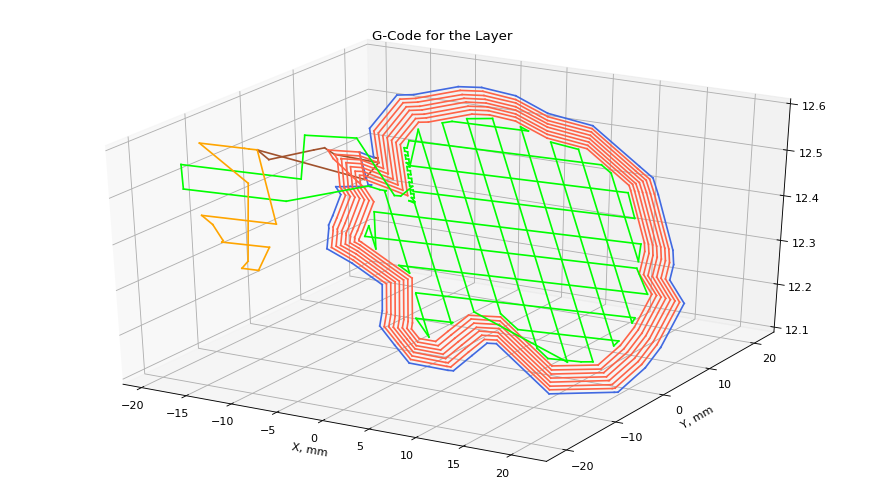

In [33]:
fig = plt.figure(figsize=(14, 8), dpi=80)
ax = fig.add_subplot(111, projection='3d')
for i in range(len(X_active_default)):
    ax.plot([X_active_default[i],X_active_default[i-1]],
        [Y_active_default[i],Y_active_default[i-1]],
        [Z_active_default[i],Z_active_default[i-1]],color='sienna')

for i in range(len(X_active_wall_outer)):
    ax.plot([X_active_wall_outer[i],X_active_wall_outer[i-1]],
        [Y_active_wall_outer[i],Y_active_wall_outer[i-1]],
        [Z_active_wall_outer[i],Z_active_wall_outer[i-1]],color='royalblue')

for i in range(len(X_active_wall_inner)):
    ax.plot([X_active_wall_inner[i],X_active_wall_inner[i-1]],
        [Y_active_wall_inner[i],Y_active_wall_inner[i-1]],
        [Z_active_wall_inner[i],Z_active_wall_inner[i-1]],color='tomato')

for i in range(len(X_active_fill)):
    ax.plot([X_active_fill[i],X_active_fill[i-1]],
        [Y_active_fill[i],Y_active_fill[i-1]],
        [Z_active_fill[i],Z_active_fill[i-1]],color='lime')

for i in range(len(X_active_support)):
    ax.plot([X_active_support[i],X_active_support[i-1]],
        [Y_active_support[i],Y_active_support[i-1]],
        [Z_active_support[i],Z_active_support[i-1]],color='orange')

for i in range(len(X_active_support_interface)):
    ax.plot([X_active_support_interface[i],X_active_support_interface[i-1]],
        [Y_active_support_interface[i],Y_active_support_interface[i-1]],
        [Z_active_support_interface[i],Z_active_support_interface[i-1]],color='cyan')
ax.set_xlabel('X, mm')
ax.set_ylabel('Y, mm')
ax.set_title('G-Code for the Layer')
plt.show()

In [34]:
def getEquidistantPoints(p1, p2, parts):
    return zip(np.linspace(p1[0], p2[0], parts+1), np.linspace(p1[1], p2[1], parts+1))

In [35]:
stl_outline_x = []
stl_outline_y = []
number_of_additional_points = 10

for i in range(np.shape(P1[0])[0]):
    for j in range(len(list(getEquidistantPoints((P1[0][i][0],P1[0][i][1]),(P1[0][i-1][0],P1[0][i][1]),\
                                                 number_of_additional_points)))):
        xx = list(getEquidistantPoints((P1[0][i-1][0],P1[0][i-1][1]),(P1[0][i][0],P1[0][i][1]),\
                                       number_of_additional_points))[j][0]
        yy = list(getEquidistantPoints((P1[0][i-1][0],P1[0][i-1][1]),(P1[0][i][0],P1[0][i][1]),\
                                       number_of_additional_points))[j][1]
        stl_outline_x.append(xx)
        stl_outline_y.append(yy)
    stl_outline_x.append(P1[0][i][0])
    stl_outline_y.append(P1[0][i][1])

### --------------- Interpolate Points and Create Masks
stl_out_shape = np.vstack([(stl_outline_x),(stl_outline_y)])
stl_out_shape = np.vstack([(stl_out_shape[0]),(stl_out_shape[1])])

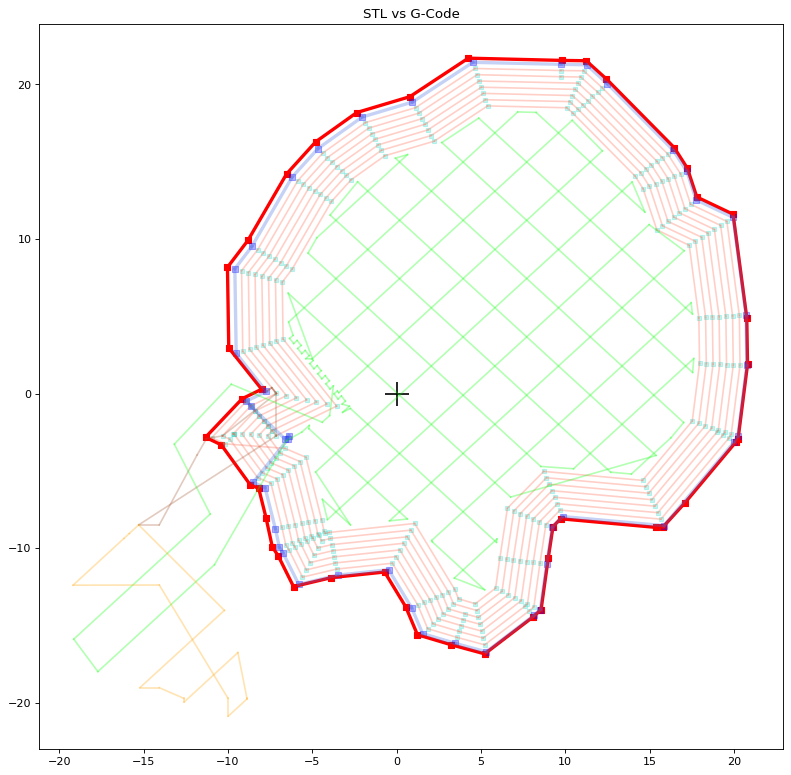

In [36]:
fig = plt.figure(figsize=(12,12), dpi=80)
plt.subplot(111)
for i in range(np.shape(P1[0])[0]):
    for j in range(len(list(getEquidistantPoints((P1[0][i][0],P1[0][i][1]),(P1[0][i-1][0],P1[0][i][1]),\
                                                 number_of_additional_points)))):
        xx = list(getEquidistantPoints((P1[0][i-1][0],P1[0][i-1][1]),(P1[0][i][0],P1[0][i][1]),\
                                       number_of_additional_points))[j][0]
        yy = list(getEquidistantPoints((P1[0][i-1][0],P1[0][i-1][1]),(P1[0][i][0],P1[0][i][1]),\
                                       number_of_additional_points))[j][1]
        #plt.scatter(xx,yy,color='b',s=20)
        stl_outline_x.append(xx)
        stl_outline_y.append(yy)

    plt.plot([P1[0][i][0],P1[0][i-1][0]],[P1[0][i][1],P1[0][i-1][1]],color='red',linewidth=3)
    plt.scatter(P1[0][i][0],P1[0][i][1],marker='s',color='red',s=25)
    stl_outline_x.append(P1[0][i][0])
    stl_outline_y.append(P1[0][i][1])
#plt.xlim(-15, 25)
#plt.ylim(-20, 20)

for i in range(len(X_active_wall_inner)):
    plt.scatter(X_active_wall_inner[i],Y_active_wall_inner[i],marker='s',c='turquoise',s=10,alpha=0.3)
    plt.plot([X_active_wall_inner[i],X_active_wall_inner[i-1]],
        [Y_active_wall_inner[i],Y_active_wall_inner[i-1]],color='tomato',alpha=0.3)
    
for i in range(len(X_active_default)):
    plt.plot([X_active_default[i],X_active_default[i-1]],
        [Y_active_default[i],Y_active_default[i-1]],color='sienna',alpha=0.3)

for i in range(len(X_active_wall_outer)):
    plt.plot([X_active_wall_outer[i],X_active_wall_outer[i-1]],\
        [Y_active_wall_outer[i],Y_active_wall_outer[i-1]],color='royalblue',linewidth=3,alpha=0.3)
    plt.scatter(X_active_wall_outer[i],Y_active_wall_outer[i],marker='s',c='blue',s=25,alpha=0.3)

for i in range(len(X_active_fill)):
    plt.plot([X_active_fill[i],X_active_fill[i-1]],
        [Y_active_fill[i],Y_active_fill[i-1]],color='lime',alpha=0.3)

for i in range(len(X_active_support)):
    plt.plot([X_active_support[i],X_active_support[i-1]],
        [Y_active_support[i],Y_active_support[i-1]],color='orange',alpha=0.3)
plt.scatter(0,0,c='k',s=500,marker='+')

plt.title('STL vs G-Code')
plt.show()

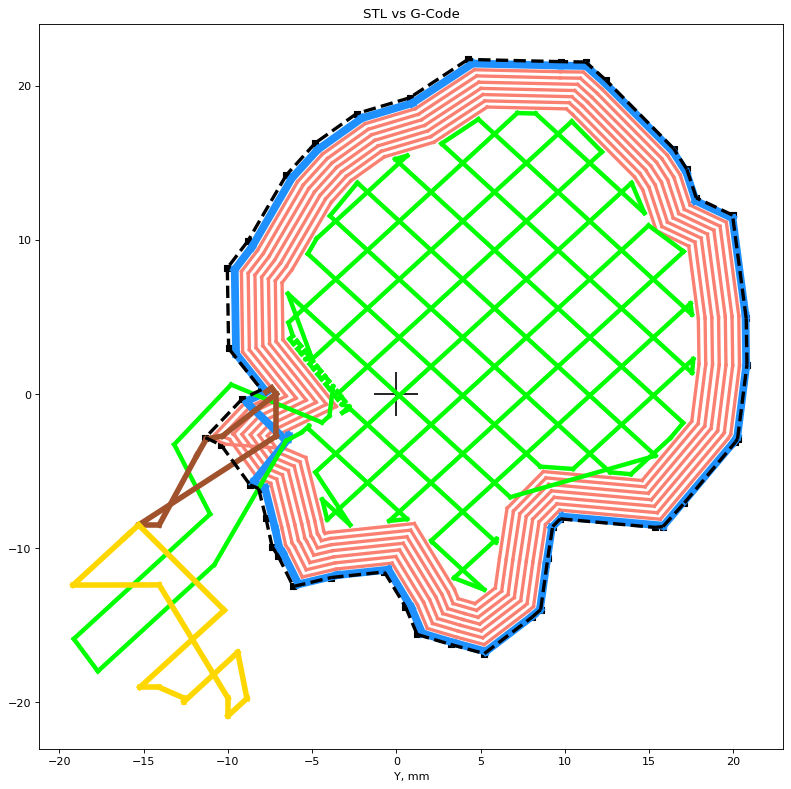

In [37]:
fig = plt.figure(figsize=(12,12), dpi=80)
plt.subplot(111)

for i in range(len(X_active_wall_inner)):
    #plt.scatter(X_active_wall_inner[i],Y_active_wall_inner[i],marker='s',c='k',s=10,alpha=1)
    plt.plot([X_active_wall_inner[i],X_active_wall_inner[i-1]],
        [Y_active_wall_inner[i],Y_active_wall_inner[i-1]],color='salmon',linewidth=3,alpha=1)

for i in range(len(X_active_wall_outer)):
    plt.plot([X_active_wall_outer[i],X_active_wall_outer[i-1]],\
        [Y_active_wall_outer[i],Y_active_wall_outer[i-1]],color='dodgerblue',linewidth=7,alpha=1)
    
for i in range(len(X_active_fill)):
    plt.plot([X_active_fill[i],X_active_fill[i-1]],
        [Y_active_fill[i],Y_active_fill[i-1]],color='lime',linewidth=4,alpha=1)
    
for i in range(len(X_active_default)):
    plt.plot([X_active_default[i],X_active_default[i-1]],
        [Y_active_default[i],Y_active_default[i-1]],color='sienna',alpha=1,linewidth=5)

for i in range(len(X_active_support)):
    plt.plot([X_active_support[i],X_active_support[i-1]],
        [Y_active_support[i],Y_active_support[i-1]],color='gold',linewidth=5,alpha=1)


for i in range(np.shape(P1[0])[0]):
    for j in range(len(list(getEquidistantPoints((P1[0][i][0],P1[0][i][1]),(P1[0][i-1][0],P1[0][i][1]),\
                                                 number_of_additional_points)))):
        xx = list(getEquidistantPoints((P1[0][i-1][0],P1[0][i-1][1]),(P1[0][i][0],P1[0][i][1]),\
                                       number_of_additional_points))[j][0]
        yy = list(getEquidistantPoints((P1[0][i-1][0],P1[0][i-1][1]),(P1[0][i][0],P1[0][i][1]),\
                                       number_of_additional_points))[j][1]
        #plt.scatter(xx,yy,color='b',s=20)
        stl_outline_x.append(xx)
        stl_outline_y.append(yy)

    plt.plot([P1[0][i][0],P1[0][i-1][0]],[P1[0][i][1],P1[0][i-1][1]],color='k',linewidth=3,linestyle='--')
    plt.scatter(P1[0][i][0],P1[0][i][1],marker='s',color='k',s=25)
    stl_outline_x.append(P1[0][i][0])
    stl_outline_y.append(P1[0][i][1])
plt.scatter(0,0,c='k',s=1550,marker='+')
plt.xlabel('X, mm')
plt.xlabel('Y, mm')
plt.title('STL vs G-Code')
plt.show()